In [1]:
%load_ext autoreload
%autoreload complete

%matplotlib inline

import gsvd
from save_gsvds import save_gsvds
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import glob
import re
import warnings
import math
from os.path import join
from pathlib import Path
from datetime import date, datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import seaborn as sns
from dotenv import dotenv_values
import itertools
import pickle
from tqdm.notebook import tqdm
import pyarrow.parquet as pq
from scipy.sparse import csgraph
import scipy.linalg
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.cluster._spectral import cluster_qr
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

sns.set_theme(style="darkgrid")

cfg = dotenv_values()

dat_dir = cfg['DAT_DIR']

alpha = 1  # Regularisation parameter
file_date = '2024-11-27'
postfix = ''  # Optional
typing_mats_file = join(dat_dir, "typing_mat_dict_2024-10-28.pkl")
svd_mats_file = join(dat_dir, f"svd_mats_alpha{alpha}_{file_date}{postfix}.pkl")
sleep_pred_file = join(dat_dir, f"spleep_pred_10_90_alpha{alpha}_{file_date}{postfix}.parquet")

/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Data to matrices

## Key presses

In [2]:
dat_kp: pd.DataFrame = pq.read_table(join(dat_dir, 'CLEAR3_processed_2024-10-24', 'dat_kp.parquet')).to_pandas()

In [12]:
len(dat_kp['subject'].unique())

143

Important: Add twelve hours to every timestamp so the nights will appear in the centre of our future data matrices. We do this because the daily rating of every night's sleep is about the previous night, i.e. the rating for day n will be for the night that started on day n-1.

In [3]:
# Retain the original timestamp column for sanity checks later on
og_keypressTimestampLocal = pd.to_datetime(dat_kp['keypressTimestampLocal'])

dat_kp['keypressTimestampLocal'] = og_keypressTimestampLocal + timedelta(hours = 12)

# Pandas has trouble computing the min of a date, so convert back to datetime
dat_kp['date'] = pd.to_datetime(dat_kp['keypressTimestampLocal'].dt.date)
dat_kp['hour'] = dat_kp['keypressTimestampLocal'].dt.hour

## Accelerometer

In [4]:
dat_ses: pd.DataFrame = pq.read_table(join(dat_dir, 'CLEAR3_processed_2024-10-24', 'dat_ses.parquet')).to_pandas()

Here too, we shift all timestamps by +12 hours.

In [5]:
dat_ses['sessionTimestampLocal'] = dat_ses['sessionTimestampLocal'] + timedelta(hours=12)

dat_ses['date'] = pd.to_datetime(dat_ses['sessionTimestampLocal'].dt.date)
dat_ses['hour'] = dat_ses['sessionTimestampLocal'].dt.hour

## Merge and transform

In [63]:
# Takes about a minute on fast hardware
typing_matrices, dates = gsvd.get_typing_matrices(dat_kp, dat_ses)

## Save to / load from file

In [64]:
typing_mat_dict = {
    "typing_matrices": typing_matrices,
    "dates": dates
}

with open(typing_mats_file, 'wb') as f:
    pickle.dump(typing_mat_dict, f)

In [2]:
with open(typing_mats_file, 'rb') as f:
    typing_mat_dict = pickle.load(f)

typing_matrices: dict[str, dict[str, pd.DataFrame]] = typing_mat_dict["typing_matrices"]
dates: pd.DataFrame = typing_mat_dict["dates"]

In [3]:
len(list(typing_matrices.keys()))

91

Total number of days:

In [4]:
np.sum([dfs['n_presses'].shape[0] for dfs in typing_matrices.values()])

7921

# Calculate graph-regularized SVD

## Train-test for all participants

In [56]:
svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, train_ratio=0.1)

  0%|          | 0/91 [00:00<?, ?it/s]

/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3034
  warnings.warn(f"No data in training set for participant {subject}")
/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3061
  warnings.warn(f"No data in training set for participant {subject}")
/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3132
  warnings.warn(f"No data in training set for participant {subject}")


In [57]:
# Saving
with open(svd_mats_file, 'wb') as f:
    pickle.dump(svd_mats, f)

In [3]:
# Loading
with open(svd_mats_file, 'rb') as f:
    svd_mats: dict[str, dict[str, np.ndarray]] = pickle.load(f)

## Plot GSVDs and histograms

In [11]:
from matplotlib.ticker import FixedLocator

mpl.rcParams.update({
    'font.size': 22,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 20
})

def plot_svds(svd_mats: dict[str, np.ndarray], typing_matrices: dict[str, dict[str, pd.DataFrame]]):
    n_participants = len(svd_mats)

    ncol = 6
    nrow = math.ceil(n_participants / ncol)

    f, ax = plt.subplots(nrows=nrow, ncols=ncol, #sharex=True,
                         figsize=(30,60), facecolor='w')

    warpedIdx = pd.Index(np.concatenate((np.arange(12, 24), np.arange(0, 12))))

    # max_val = np.max([
    #     np.max(np.vstack((svd_mat['train'],svd_mat['test']))) for svd_mat in svd_mats.values()
    # ])

    max_val = 4.5
    
    cmap = plt.get_cmap('viridis').copy()
    cmap.set_extremes(under='#47ccca', over='#eb4d42')

    for i, participant in enumerate(tqdm(svd_mats)):
        row = i // ncol
        col = i % ncol
        a = ax[row, col]

        ikd_df = typing_matrices[participant]['IKD']

        split_idx = None
        svd_mat = svd_mats[participant]
        if 'train' in svd_mat:
            # At which day to draw the split line
            split_idx = svd_mat['train'].shape[0]
            
            svd_mat = np.vstack((
                svd_mat['train'],
                svd_mat['test']
            ))

        im = a.imshow(svd_mat, cmap=cmap, vmin=0, vmax=max_val, aspect='auto')

        a.grid(False)
        
        if split_idx is not None:
            sns.lineplot(x=[-0.5, 23.5], y=[split_idx-0.5]*2, color='orange', ax=a)
        
        # Fix the location of the ticks before setting the labels
        a.yaxis.set_major_locator(
            FixedLocator(np.arange(svd_mat.shape[0]), nbins=10))
        yticks = a.get_yticks()
        a.set_yticklabels(ikd_df.index.values.astype(int), rotation=0)

        # Unless we've reached the bottom-most plots, turn off x-axis
        if i < n_participants - ncol:
            a.xaxis.set_visible(False)
            xlabel = None
        else:
            xlabel = 'Hour'
            # Create x ticks that go from 12 to 23, then 0 to 11
            a.set_xticks(np.arange(24, step=2), 
                         np.concatenate((
                             np.arange(12, 24, step=2), 
                             np.arange(12, step=2)
                         )))
        
        ylabel = 'Day' if col == 0 else None
        a.set(title=f"Participant {i+1}", xlabel=xlabel, ylabel=ylabel)

    # Delete empty axes
    for j in range(i+1, nrow*ncol):
        row = j // ncol
        col = j % ncol
        
        f.delaxes(ax[row, col])
    
    f.tight_layout()

    f.subplots_adjust(top=0.97)
    cbar_ax = f.add_axes([0.15, 0.99, 0.7, 0.005])
    f.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='max', cmap=cmap)

    # f.savefig(f"images/svds_train_test_10_90_{file_date}_alpha{alpha}.pdf")
    f.savefig(f"images/svds_illustration_supplement.pdf")

plt.close()

mpl.use('Agg')
# mpl.use('module://matplotlib_inline.backend_inline')

# Filter out controls
tm = {k: v for k, v in typing_matrices.items() if int(k) < 3400}
sm = {k: v for k, v in svd_mats.items() if k in tm}

plot_svds(sm, tm)

mpl.use('module://matplotlib_inline.backend_inline')

  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
def plot_mat(df: pd.DataFrame, a: Axes, cbar_label: str, title: str):
    sns.heatmap(df, cmap='viridis', ax=a, vmin=0, #vmax=500,
                cbar_kws={'label': cbar_label, 'fraction': 0.043})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    a.set(title=title, xlabel='Hour', ylabel='Day')

def plot_mats(
        svd_mats: dict[str, np.ndarray], 
        typing_matrices: dict[str, dict[str, pd.DataFrame]], 
        participant: str,
        save: bool = False
    ):

    part_mats = typing_matrices[participant]
    
    n_presses_df = part_mats['n_presses']
    ikd_df = part_mats['IKD']
    active_df = part_mats['active']
    upright_df = part_mats['upright']

    if participant not in svd_mats:
        warnings.warn(f"Participant {participant} has no SVD matrix, skipping")
        return

    split_idx = None
    svd_mat = svd_mats[participant]
    if 'train' in svd_mat:
        # At which day to draw the split lines
        split_idx = svd_mat['train'].shape[0]
        
        svd_mat = np.vstack((
            svd_mat['train'],
            svd_mat['test']
        ))
        
    svd_mat_df = pd.DataFrame(svd_mat, 
                              index=ikd_df.index, 
                              columns=ikd_df.columns)

    plt.rcParams.update({'font.size': 64})
    # Visualize heatmap of steps
    fig, ax = plt.subplots(nrows=3,ncols=2, sharex=False, sharey=False,
                           figsize=(20,25), facecolor='w')

    # PLOT 1
    plot_mat(np.log1p(n_presses_df), ax[0, 0], 
             cbar_label='log(1 + #Keypresses)', title='Input typing activity')

    # PLOT 2
    plot_mat(ikd_df, ax[0, 1], 
             cbar_label='Median IKD (s)', title='Input typing speed')

    # PLOT 3
    plot_mat(upright_df, ax[1, 0], 
             cbar_label='Movement rate', title='Input movement rate')

    # PLOT 4
    plot_mat(active_df, ax[1, 1], 
             cbar_label='Upright rate', title='Input upright rate')

    # PLOT 5
    a = ax[2, 0]
    plot_mat(svd_mat_df, a, 
             cbar_label='Value', title='Graph-regularised SVD')
    
    if split_idx is not None:
        sns.lineplot(x=np.arange(0, 25), y=[split_idx]*25, color='orange', ax=a)

    fig.tight_layout()

    if save:
        fig.savefig(join(
            'images', 
            f"all_mats_train_test_{participant}_alpha{alpha}_{file_date}{postfix}.pdf"
        ))

mpl.use('Agg')

for participant in tqdm(typing_matrices):
    plt.close()

    plot_mats(svd_mats, typing_matrices, participant, save=True)

mpl.use('module://matplotlib_inline.backend_inline')

In [ ]:
for participant in svd_mats:
    plt.close()
    sns.histplot(svd_mats[participant]['test'].flatten())
    plt.title(participant)
    plt.show()

## Plot binarisation illustration

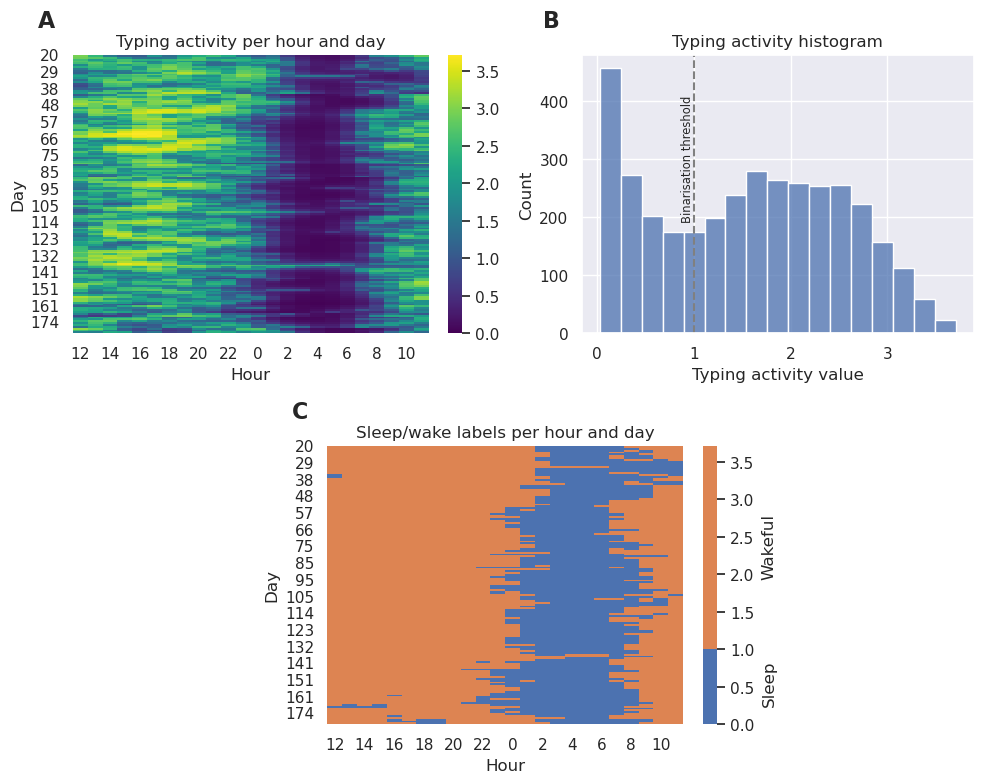

In [20]:
%matplotlib inline

warpedIdx = pd.Index(np.concatenate((np.arange(12, 24), np.arange(0, 12))))

plt.close()

participant = '3009'

part_mats = typing_matrices[participant]
ikd_df = part_mats['IKD']

fig = plt.figure(figsize=(10, 8))
spec = fig.add_gridspec(2, 4)

svd_mat = svd_mats[participant]

day_index = part_mats['IKD'].index.astype(int)

split_idx = svd_mat['train'].shape[0]
svd_df = pd.DataFrame(svd_mat['test'],
                      index=day_index[split_idx:],
                      columns=warpedIdx)

# GSVD matrix
a = fig.add_subplot(spec[0, :2])

sns.heatmap(svd_df, cmap='viridis', vmin=0,#vmax=0.25,
            cbar_kws={'fraction': 0.043}, ax=a)

a.set_title("Typing activity per hour and day")
a.set_xlabel('Hour')
a.set_ylabel('Day')
a.tick_params(axis='x', labelrotation=0)

a.text(-0.1, 1.1, 'A', transform=a.transAxes, 
       size=16, weight='bold')

# Histogram
a = fig.add_subplot(spec[0, 2:])

threshold = 1

sns.histplot(svd_mat['test'].flatten(), ax=a)

a.annotate("Binarisation threshold", 
           xy=(threshold, 300), rotation='vertical', 
           ha='right', va='center', fontsize='x-small')
a.axvline(x=threshold, color='grey', linestyle='dashed')

a.set_title("Typing activity histogram")
a.set_xlabel("Typing activity value")

a.text(-0.1, 1.1, 'B', transform=a.transAxes, 
       size=16, weight='bold')

# Binarized matrix
a = fig.add_subplot(spec[1, 1:3])

max_val = np.max(svd_mat['test'])
binary_df = (svd_df > threshold) * max_val
sns.heatmap(binary_df, cmap=sns.color_palette(n_colors=2), vmin=0, vmax=max_val,
            cbar_kws={'fraction': 0.043}, ax=a, center=threshold)
a.set_title("Sleep/wake labels per hour and day")
a.set_xlabel('Hour')
a.set_ylabel('Day')
a.tick_params(axis='x', labelrotation=0)

a.text(-0.1, 1.1, 'C', transform=a.transAxes, 
       size=16, weight='bold')

a.text(1.22, 0.64, 'Wakeful', transform=a.transAxes, 
       rotation=90, va='center')
a.text(1.22, 0.15, 'Sleep', transform=a.transAxes, 
       rotation=90, va='center')

fig.tight_layout()

fig.savefig(join('images', 'binarisation_feature_scaling.pdf'))

plt.show()

## Plot regularisation sensitivity analysis

In [59]:
with open(join(dat_dir, "svd_mats_alpha0.1_2024-11-25.pkl"), 'rb') as f:
    svd_mats_01: dict[str, dict[str, np.ndarray]] = pickle.load(f)

with open(join(dat_dir, "svd_mats_alpha1_2024-11-27.pkl"), 'rb') as f:
    svd_mats_1: dict[str, dict[str, np.ndarray]] = pickle.load(f)

with open(join(dat_dir, "svd_mats_alpha10_2024-11-27.pkl"), 'rb') as f:
    svd_mats_10: dict[str, dict[str, np.ndarray]] = pickle.load(f)

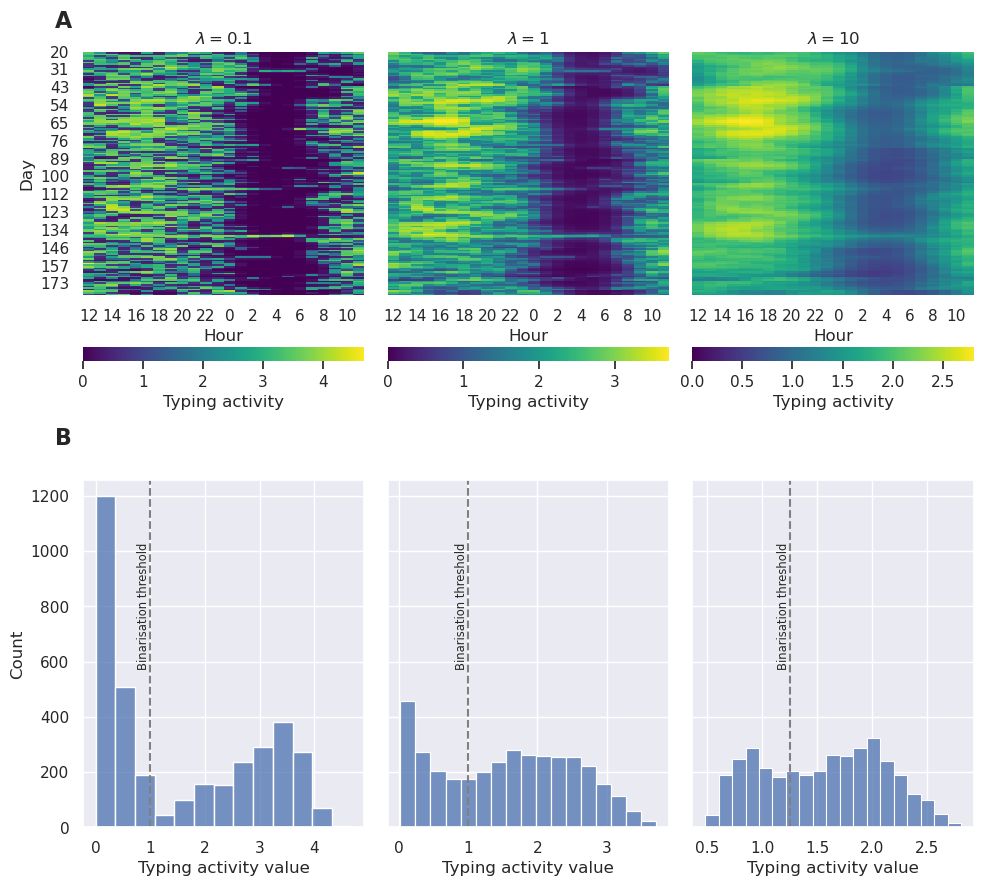

In [63]:
%matplotlib inline

participant = '3009'
part_mats = typing_matrices[participant]

warpedIdx = pd.Index(np.concatenate((np.arange(12, 24), np.arange(0, 12))))

plt.close()

fig, ax = plt.subplots(nrows=2, ncols=3, sharey='row', figsize=(10, 9))

def get_svd_mat(svd_mats, part_mats, participant):
    svd_mat = svd_mats[participant]

    day_index = part_mats['IKD'].index.astype(int)
    
    split_idx = svd_mat['train'].shape[0]
    svd_df = pd.DataFrame(svd_mat['test'],
                          index=day_index[split_idx:],
                          columns=warpedIdx)

    return svd_df

def plot_mat_svd(svd_df, a, title, tag='', ylabel=''):
    sns.heatmap(svd_df, cmap='viridis', vmin=0, ax=a,
                cbar_kws={'label': 'Typing activity', 'location': 'bottom'})
    
    a.set_title(title)
    a.set_xlabel('Hour')
    a.set_ylabel(ylabel)
    a.tick_params(axis='x', labelrotation=0)
    
    a.text(-0.1, 1.1, tag, transform=a.transAxes, 
           size=16, weight='bold')

def plot_hist_svd(svd_df, a, threshold, tag=''):
    sns.histplot(svd_df.values.flatten(), ax=a)
    
    a.annotate("Binarisation threshold", 
               xy=(threshold, 800), rotation='vertical', 
               ha='right', va='center', fontsize='x-small')
    a.axvline(x=threshold, color='grey', linestyle='dashed')
    
    a.set_xlabel("Typing activity value")

    a.text(-0.1, 1.1, tag, transform=a.transAxes, 
           size=16, weight='bold')

svd_df_01 = get_svd_mat(svd_mats_01, part_mats, participant)
svd_df_1 = get_svd_mat(svd_mats_1, part_mats, participant)
svd_df_10 = get_svd_mat(svd_mats_10, part_mats, participant)

# GSVD matrices
plot_mat_svd(svd_df_01, ax[0, 0], 
             title=r'$\lambda = 0.1$', tag='A', ylabel='Day')

plot_mat_svd(svd_df_1, ax[0, 1], 
             title=r'$\lambda = 1$')

plot_mat_svd(svd_df_10, ax[0, 2], 
             title=r'$\lambda = 10$')

# Histograms
plot_hist_svd(svd_df_01, ax[1, 0], threshold=1, tag='B')

plot_hist_svd(svd_df_1, ax[1, 1], threshold=1)

plot_hist_svd(svd_df_10, ax[1, 2], threshold=1.25)

fig.tight_layout()

fig.savefig(join('images', 'regularisation_sensitivity_analysis.pdf'))

plt.show()

# Combine GSVD results with Oura data

In [ ]:
activity_scores = dict()

for participant, mats in svd_mats.items():
    # Construct train-test labels
    n_train = mats['train'].shape[0]
    n_test = mats['test'].shape[0]
    labels = ['train'] * n_train + ['test'] * n_test

    # Fuse train and test data
    svd_mat = np.vstack((mats['train'], mats['test']))

    # Convert to DataFrame
    ikd_index = typing_matrices[participant]['IKD'].index
    svd_df = pd.DataFrame(svd_mat, index=ikd_index)

    # Sum over the rows, add train-test labels
    scores = svd_df.sum(axis=1).to_frame(name='activity')
    scores['label'] = labels

    # Binarize data, add to scores DataFrame
    binary_df = svd_df > 1.25 # Threshold based on visual inspection
    hour_estimates = 24 - binary_df.sum(axis=1)
    scores['hour_estimate'] = hour_estimates

    # Add some measures of data quantity
    n_presses_mat = typing_matrices[participant]['n_presses']
    
    scores['n_total_presses'] = n_presses_mat.sum(axis=1)
    scores['n_active_hours'] = (n_presses_mat > 0).sum(axis=1)

    # plt.close()
    # sns.heatmap(binary_df)
    # plt.show()

    activity_scores[participant] = scores

activity_scores = pd.concat(activity_scores, names=['subject'])

# activity_scores

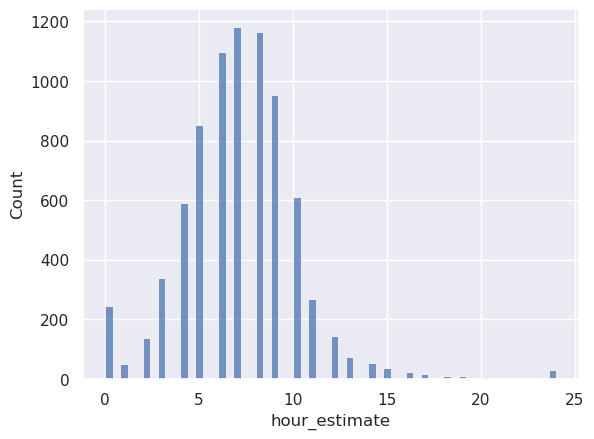

In [20]:
sns.histplot(activity_scores, x='hour_estimate')
plt.show()

In [ ]:
dates['date'] = pd.to_datetime(dates['date'])

date_df = dates.set_index(['subject', 'dayNumber'], drop=False) \
    .join(activity_scores) \
    .set_index(['subject', 'date'])

# date_df

In [ ]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()

self_reports['id'] = self_reports['id'].astype(str)
self_reports['daterated'] = pd.to_datetime(self_reports['daterated'])

self_reports = self_reports.rename(columns={'id': 'subject', 'daterated': 'date'})
self_reports = self_reports.set_index(['subject', 'date'])

# self_reports

In [ ]:
dat_oura = pd.read_parquet(join(dat_dir, 'CLEAR3_Biaffect_Leow', 'clear3baseline_sleep.parquet'))

dat_oura['baseline'] = True

dat_oura['id'] = dat_oura['id'].astype(int).astype(str)
dat_oura['daterated'] = pd.to_datetime(dat_oura['daterated'])

dat_oura = dat_oura.rename(columns={'id': 'subject', 'daterated': 'date'})
dat_oura = dat_oura.set_index(['subject', 'date'])

# dat_oura

In [ ]:
sleep_pred = dat_oura.join(date_df, how='outer')
sleep_pred['baseline'] = sleep_pred['baseline'].fillna(False)

sleep_pred = sleep_pred.reset_index()
sleep_pred['date'] = sleep_pred['date'].dt.date

# sleep_pred

In [24]:
sleep_pred.to_parquet(sleep_pred_file)

# Spectral clustering

## Histograms

In [5]:
# Range of all the GSVD matrices, falls neatly in [0, 1]
svd_mats_list = [svd_mat['test'] for svd_mat in svd_mats.values()]
svd_mats_stacked = np.vstack(svd_mats_list)
np.min(svd_mats_stacked), np.max(svd_mats_stacked)

(5.339594215175079e-07, 0.9940318975837107)

In [6]:
n_bins = 15

svd_mat = svd_mats_list[0]
hist, bin_edges = np.histogram(svd_mat, bins=n_bins, range=(0, 1), density=True)
bin_locs = np.convolve(bin_edges, [0.5, 0.5], "valid") # Pairwise average

In [7]:
hists = {p: np.histogram(svd['test'], bins=n_bins, range=(0, 1), density=True)[0] for p, svd in svd_mats.items()}

In [ ]:
# %matplotlib inline

plt.close()

n_cols = 4
n_rows = len(hists) // n_cols + (len(hists) % n_cols > 0)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 50), sharex='all', sharey='all')

for i, (participant, hist) in enumerate(hists.items()):
    row = i // n_cols
    col = i % n_cols

    a: Axes = ax[row, col]
    
    a.bar(bin_locs, hist, width=1/n_bins)
    a.set_title(f"Participant {participant}")

    # Last row
    if row == n_rows - 1:
        a.set_xlabel('GSVD value')

    # First column
    if col == 0:
        a.set_ylabel('Density')

fig.tight_layout()

fig.savefig('images/histograms_alpha1.pdf')

plt.show()

In [8]:
# n_samples (participants) X n_features (bins)
hists_features = np.vstack(list(hists.values()))
hists_features.shape

(45, 15)

In [10]:
# This drops the first (smallest) component
se = SpectralEmbedding(n_components=3, affinity='rbf', eigen_solver='arpack', gamma=1/hists_features.shape[1])
embedding = se.fit_transform(hists_features)

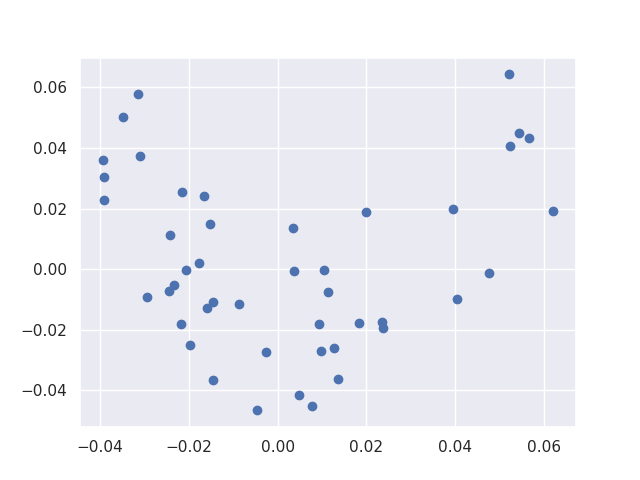

In [11]:
# %matplotlib inline

plt.close()

plt.scatter(embedding[:, 0], embedding[:, 1])

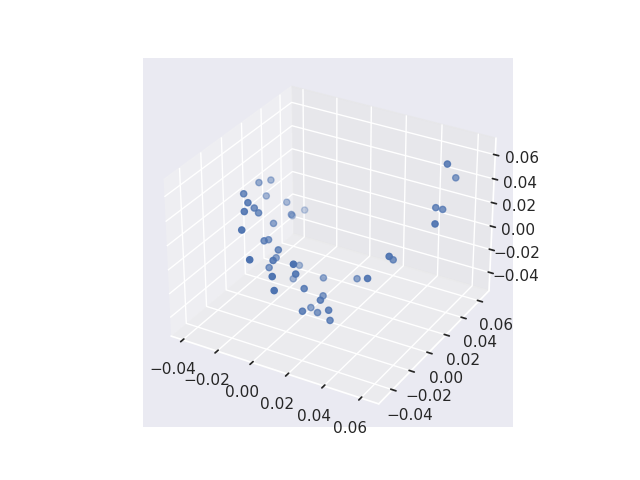

In [12]:
# %matplotlib

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])

plt.show()

In [13]:
sc = SpectralClustering(n_clusters=2, affinity='rbf', eigen_solver='arpack', assign_labels='kmeans', n_components=3, gamma=1/hists_features.shape[1])
sc.fit_predict(hists_features)

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0], dtype=int32)

In [14]:
# First component (corresponds to smallest eigenvalue) is constant
embedding2 = spectral_embedding(sc.affinity_matrix_, n_components=3, eigen_solver='arpack', drop_first=True)

# Same clusters as from SpectralClustering.fit_predict, confirming that we have the right embedding
# labels = cluster_qr(embedding2)
k_means = KMeans(init="k-means++", n_clusters=2, n_init=10)
labels = k_means.fit_predict(embedding2)
labels

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1], dtype=int32)

<Axes: xlabel='x', ylabel='y'>

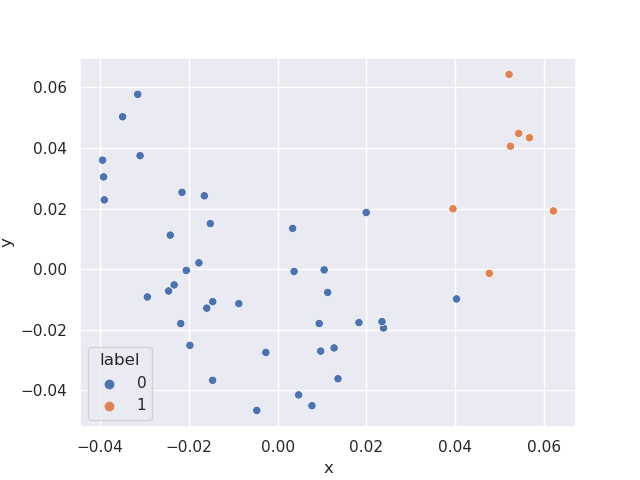

In [15]:
plt.close()

col_names = ['x', 'y', 'z']
emb_df = pd.DataFrame(embedding2, columns=col_names[:embedding2.shape[1]])
emb_df['label'] = labels

sns.scatterplot(emb_df, x='x', y='y', hue='label')

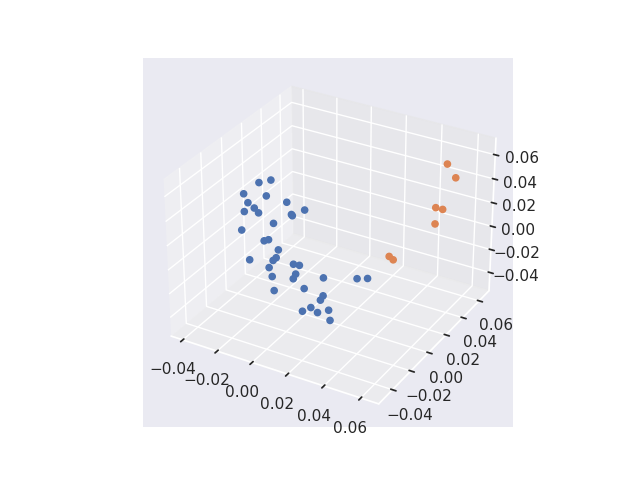

In [16]:
# %matplotlib inline

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette(n_colors=2).as_hex())

ax.scatter(embedding2[:, 0], embedding2[:, 1], embedding2[:, 2], c=labels, alpha=1, cmap=cmap)

plt.show()

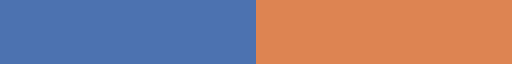

In [14]:
# get colormap from seaborn
cmap = ListedColormap(sns.color_palette(n_colors=2).as_hex())

cmap

## RMSSD

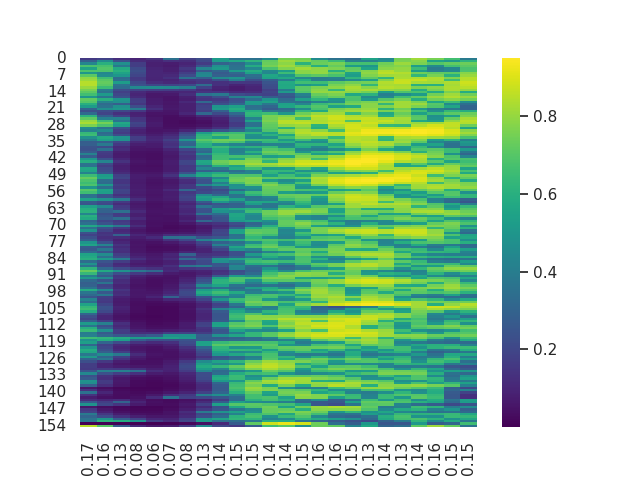

In [17]:
# %matplotlib inline

participant = '3009'

svd_mat = svd_mats[participant]['test']

# 24D vector
rmssd = np.sqrt(np.mean(np.square(np.diff(svd_mat, n=1, axis=0)), axis=0))

plt.close()

sns.heatmap(svd_mat, cmap='viridis')
plt.xticks(ticks=np.arange(24) + 0.5, labels=np.round(rmssd, 2))

plt.show()

In [26]:
rmssds = {p: np.sqrt(np.mean(np.square(np.diff(svd['test'], n=1, axis=0)), axis=0)) for p, svd in svd_mats.items()}

# n_samples (participants) X n_features (hours)
rmssds_features = np.vstack(list(rmssds.values()))
rmssds_features.shape

(45, 24)

In [ ]:
# %matplotlib inline

plt.close()

n_cols = 4
n_rows = len(rmssds) // n_cols + (len(rmssds) % n_cols > 0)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 50), sharex='all', sharey='all')

for i, (participant, rmssd) in enumerate(rmssds.items()):
    row = i // n_cols
    col = i % n_cols

    a: Axes = ax[row, col]
    
    a.bar(np.arange(24), rmssd, width=1)
    a.set_title(f"RMSSD participant {participant}")

    # Last row
    if row == n_rows - 1:
        a.set_xlabel('Hour')

    # First column
    if col == 0:
        a.set_ylabel('RMSSD')

fig.tight_layout()
fig.savefig('images/rmssds_alpha1.pdf')

plt.show()

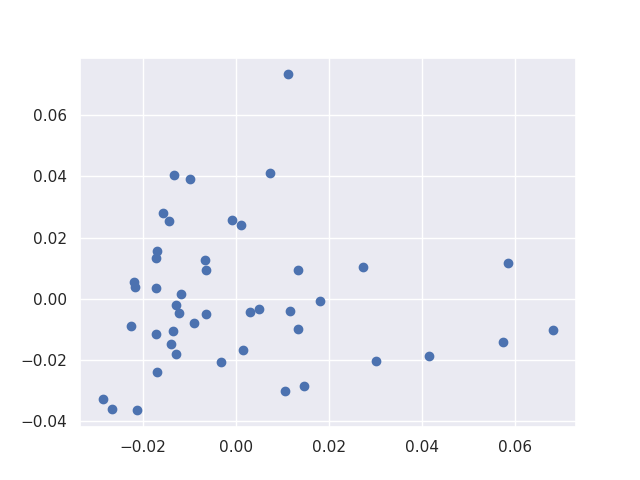

In [19]:
# This drops the first (smallest) component
se = SpectralEmbedding(n_components=3, affinity='rbf', eigen_solver='arpack', gamma=1/rmssds_features.shape[1])
embedding_rmssd = se.fit_transform(rmssds_features)

plt.close()

plt.scatter(embedding_rmssd[:, 0], embedding_rmssd[:, 1])

Clustering this will lead nowhere...

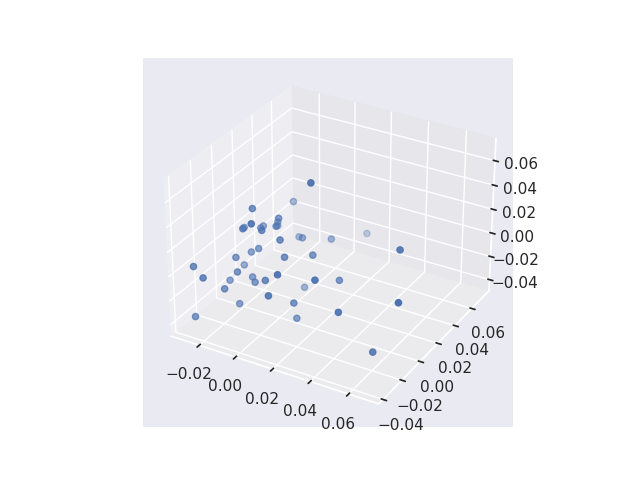

In [20]:
# %matplotlib inline

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding_rmssd[:, 0], embedding_rmssd[:, 1], embedding_rmssd[:, 2])

plt.show()

## Histogram + RMSSD

In [27]:
# n_samples (participants) X n_features (bins + hours)
all_features = np.hstack((hists_features, rmssds_features))

# Standardization
all_features = (all_features - np.mean(all_features, axis=0)) / np.std(all_features, axis=0)

all_features.shape

(45, 39)

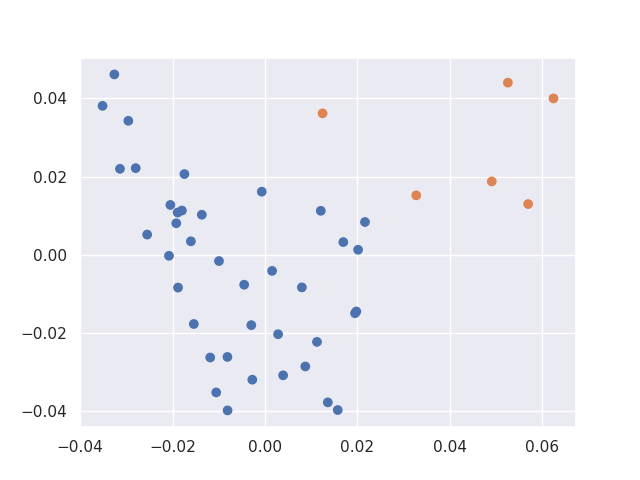

In [29]:
# %matplotlib inline

# This drops the first (smallest) component
se = SpectralEmbedding(n_components=3, affinity='rbf', eigen_solver='arpack', gamma=0.001)
embedding_all = se.fit_transform(all_features)

k_means = KMeans(init="k-means++", n_clusters=2, n_init=10)
labels = k_means.fit_predict(embedding_all)

plt.close()

plt.scatter(embedding_all[:, 0], embedding_all[:, 1], c=labels, cmap=cmap)

plt.show()

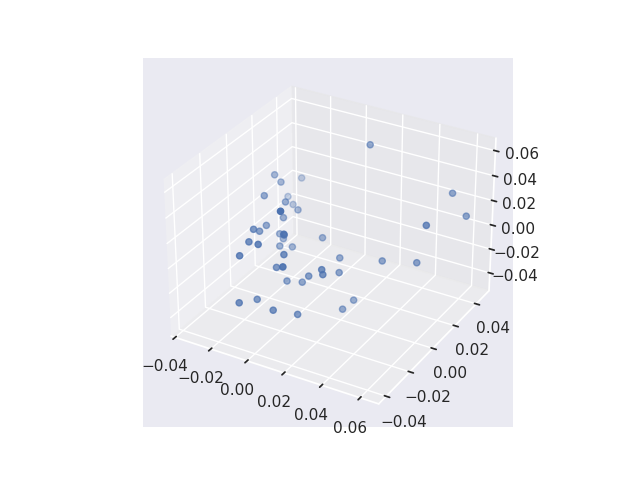

In [23]:
# %matplotlib inline

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding_all[:, 0], embedding_all[:, 1], embedding_all[:, 2])

plt.show()

In [17]:
def plot_annotated_3d(embedding, participants, labels, cmap):
    plt.close()
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, cmap=cmap)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    
    def update_annot(ind):
        """
        Set the position, text, and color of the annotation.
        
        parameters
        ----------
        ind: dict[str, array]
            A dict with key 'ind' and a 1D array as its value. The array holds the index of the data point.
        """
        
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        
        text = f"Participant {participants[ind['ind'][0]]}"
        
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor(cmap(labels[ind["ind"][0]]))
        annot.get_bbox_patch().set_alpha(0.4)
        
    
    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    
    fig.canvas.mpl_connect("motion_notify_event", hover)
    
    # fig.savefig('images/spectral_clustering.pdf')
    
    plt.show()

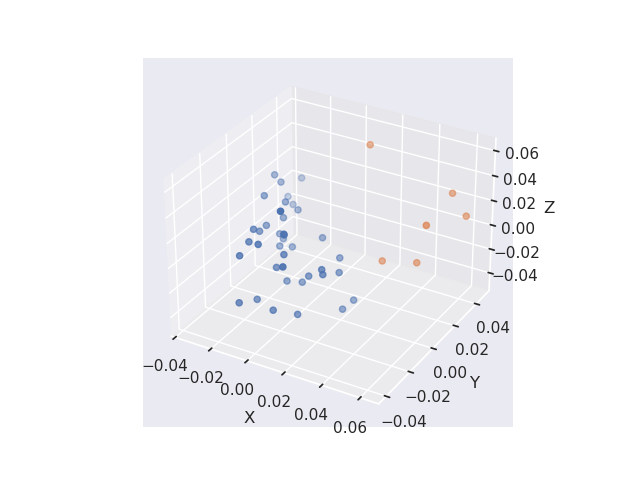

In [30]:
%matplotlib widget

participants = list(svd_mats.keys())

plot_annotated_3d(embedding_all, participants, labels, cmap)

In [ ]:
participant = '3009'

# TODO: Make plot that shows GSVD and summary features next to each other, for every participant
# Maybe color code based on cluster

## Characterizing clusters

In [39]:
cluster_df = pd.DataFrame({'cluster': labels}, index=pd.Index(participants, name='subject'))

grouped_cluster = sleep_pred.dropna() \
    .join(cluster_df, on='subject', how='inner') \
    .groupby('cluster')

print(grouped_cluster.mean(numeric_only=True))
print(grouped_cluster.std(numeric_only=True))

         sleepdur_yest  SleepLNQuality  dayNumber   activity  hour_estimate
cluster                                                                    
0             5.868136        2.348374  60.825813  12.875008       8.153200
1             5.548780        1.969512  39.469512  10.941903      10.719512
         sleepdur_yest  SleepLNQuality  dayNumber  activity  hour_estimate
cluster                                                                   
0             1.546491        0.988213  47.104396  1.965307       2.261964
1             1.316739        0.974672  38.933390  2.529458       3.008268


## Deviation from reference day

In [9]:
from sklearn.preprocessing import normalize

def mean_cosine_sim(svd_mat):
    day_mean = svd_mat.mean(axis=0)

    normed_mean = day_mean / np.linalg.norm(day_mean)
    svd_normed = normalize(svd_mat) # Normalizes every row, i.e. day
    mean_normed = svd_normed.mean(axis=0)
    
    return normed_mean @ mean_normed

participant = '3049'

svd_mat = svd_mats[participant]['test']

mean_cosine_sim(svd_mat)

0.9278091040975904

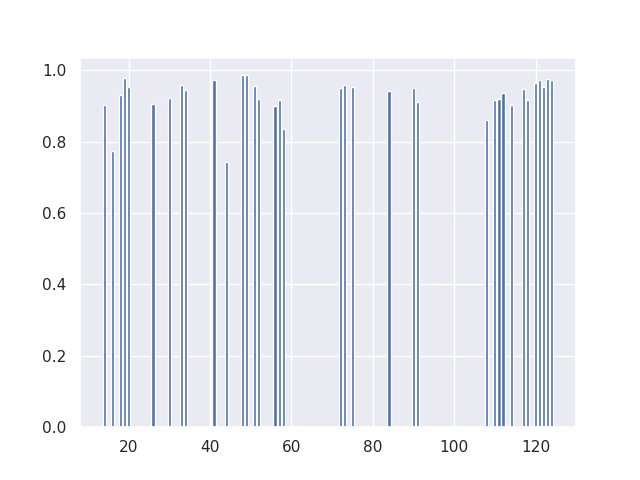

In [10]:
# (24,)
day_mean = svd_mat.mean(axis=0)

# (n_days,)
norm_factor = 1 / (np.linalg.norm(day_mean) * np.linalg.norm(svd_mat, axis=1))

# (n_days, 24)
left_factor = np.outer(norm_factor, day_mean)

# Pairwise dot product of the rows (n_days,)
cosine_sim = (left_factor * svd_mat).sum(axis=1)

plt.close()

days = typing_matrices[participant]['IKD'].index.values
plt.bar(days[-len(cosine_sim):], cosine_sim)

plt.show()

In [11]:
cosine_sims = {p: mean_cosine_sim(svd['test']) for p, svd in svd_mats.items()}

# n_samples (participants) X n_features (1)
cosine_features = np.vstack(list(cosine_sims.values()))
cosine_features.shape

(45, 1)

In [12]:
# n_samples (participants) X n_features (bins + 1)
hist_cosine_features = np.hstack((hists_features, cosine_features))

# Standardization
hist_cosine_features = (hist_cosine_features - np.mean(hist_cosine_features, axis=0)) / np.std(hist_cosine_features, axis=0)

hist_cosine_features.shape

(45, 16)

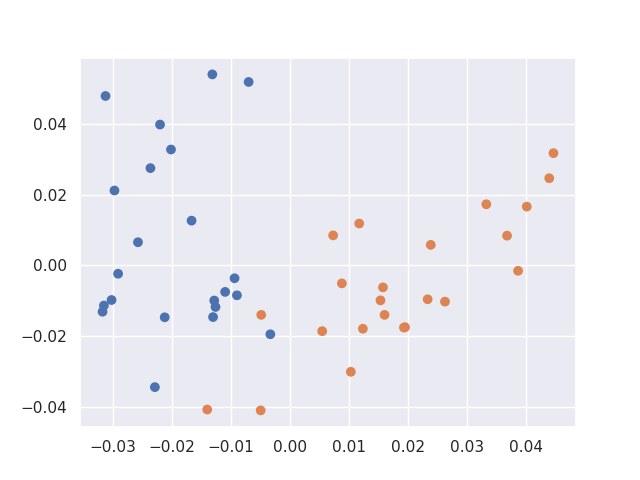

In [15]:
se = SpectralEmbedding(n_components=3, affinity='rbf', eigen_solver='arpack', gamma=0.001)
embedding_hist_cos = se.fit_transform(hist_cosine_features)

k_means = KMeans(init="k-means++", n_clusters=2, n_init=10)
labels = k_means.fit_predict(embedding_hist_cos)

plt.close()

plt.scatter(embedding_hist_cos[:, 0], embedding_hist_cos[:, 1], c=labels, cmap=cmap)

plt.show()

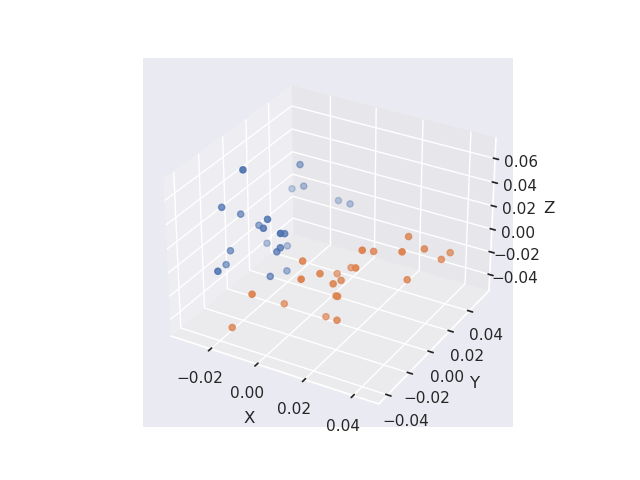

In [18]:
%matplotlib widget

participants = list(svd_mats.keys())

plot_annotated_3d(embedding_hist_cos, participants, labels, cmap)

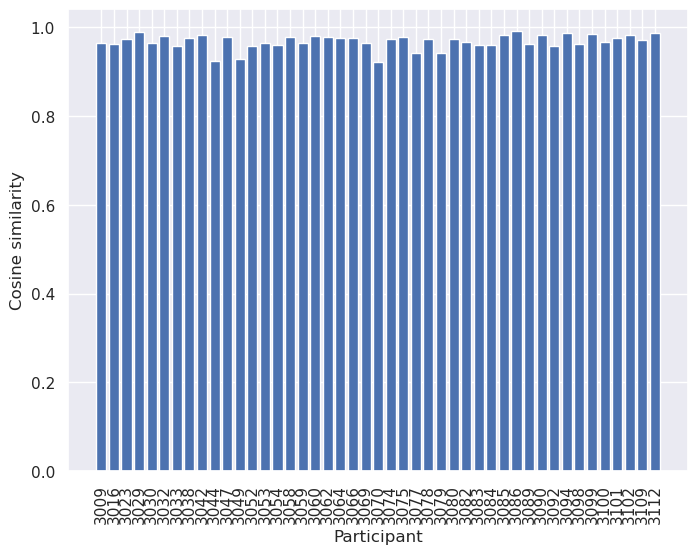

In [42]:
%matplotlib inline

plt.close()

plt.figure(figsize=(8, 6))

plt.bar(participants, cosine_features.squeeze())
plt.xticks(rotation=90)
plt.ylabel("Cosine similarity")
plt.xlabel("Participant")

plt.show()

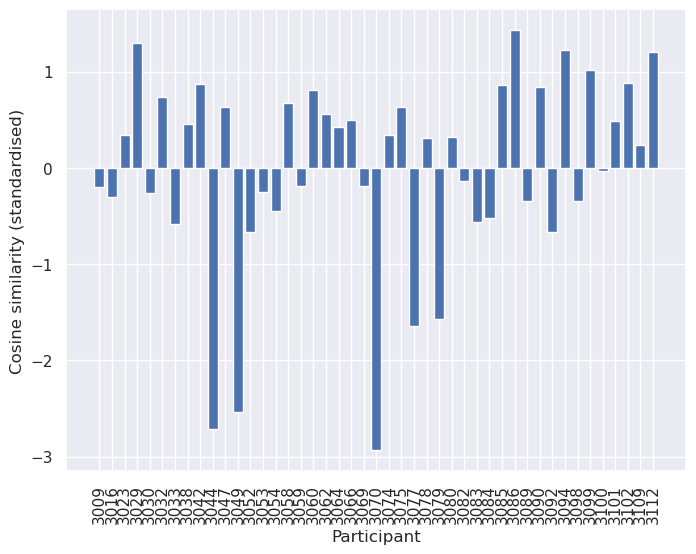

In [43]:
plt.close()

plt.figure(figsize=(8, 6))

plt.bar(participants, hist_cosine_features[:, -1])
plt.xticks(rotation=90)
plt.ylabel("Cosine similarity (standardised)")
plt.xlabel("Participant")

plt.show()

# Full rank

In [26]:
svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, rank=4, train_ratio=0.1)

  0%|          | 0/91 [00:00<?, ?it/s]

/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3034
  warnings.warn(f"No data in training set for participant {subject}")
/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3061
  warnings.warn(f"No data in training set for participant {subject}")
/home/preclineu/lorkno/Documents/Code/graph-svd/graphRegularizedSVD_sleepWakeMatrices.py:845: UserWarning: No data in training set for participant 3132
  warnings.warn(f"No data in training set for participant {subject}")


In [27]:
participant = '3009'

rank = 4

# (rank, n_days, n_hours)
svd_mat_full = svd_mats[participant]['test'].reshape((rank, -1, 24))
n_days = svd_mat_full.shape[1]

ikd_df = typing_matrices[participant]['IKD']

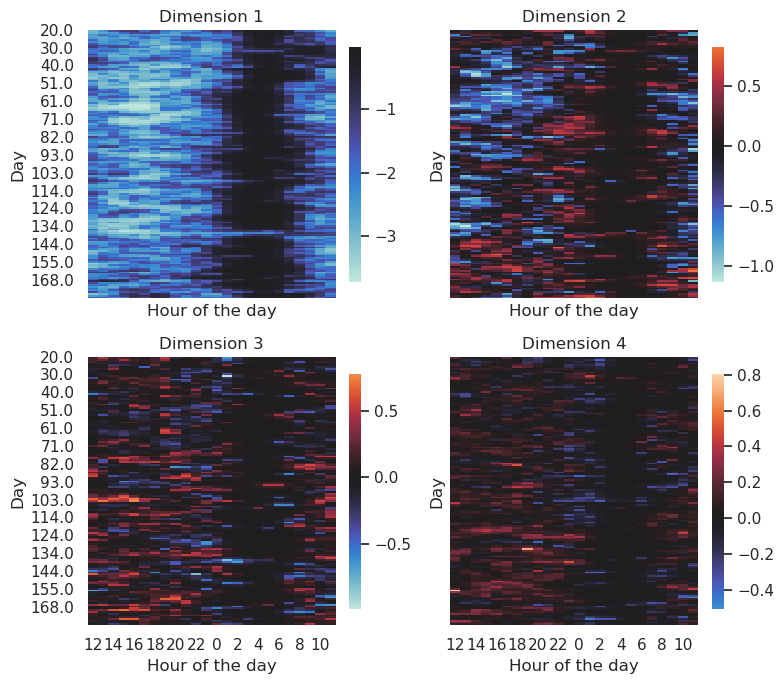

In [36]:
plt.close()

n_col = 2
n_row = math.ceil(rank / n_col)

warpedIdx = pd.Index(np.concatenate((np.arange(12, 24), np.arange(0, 12))))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, 
                        figsize=(8, 7), sharex=True, sharey=True)

for i in range(rank):
    row = i // n_col
    col = i % n_col

    ax = axs[row, col]
    
    svd_mat_df = pd.DataFrame(svd_mat_full[i, :, :], 
                              index=ikd_df.index[-n_days:], 
                              columns=warpedIdx)

    sns.heatmap(svd_mat_df, cmap='icefire', center=0,
                cbar_kws={'fraction': 0.043}, ax=ax)
    ax.set_ylabel("Day")
    ax.set_xlabel("Hour of the day")
    ax.set_title(f"Dimension {i+1}")

fig.tight_layout()

fig.savefig(join('images', 'full_rank_decomposition.pdf'))

# Old code

In [5]:
all_files = sorted(glob.glob("sub-*/preproc/*dat-kp.csv", root_dir=dat_dir, recursive=True))

pat = re.compile(r"sub-(\d+)")
subs = [re.match(pat, f).group(1) for f in all_files]

gsvd_file = 'gsvd_results.pkl'

Calculate graph SVDs, save them to file, and read them back in.

In [ ]:
# Calculate graph SVDs and save to file
save_gsvds(dat_dir, all_files, subs, out_file=gsvd_file)

In [6]:
with open(join(dat_dir, gsvd_file), 'rb') as handle:
    gsvd_results = pickle.load(handle)

Extract (complete rows of) CLEAR-3 sleep data.

In [ ]:
self_reports_raw = pd.read_csv(join(dat_dir, "clear3daily_20221205.csv"), index_col=0)
self_reports = self_reports_raw[['id', 'daterated', 'sleepdur_yest', 'SleepLNQuality']]
self_reports = self_reports.dropna()
self_reports['daterated'] = self_reports['daterated'].map(lambda d: date.fromisoformat(d))
self_reports

Generate plots of predicted and true sleep for every subject.

In [5]:
# I don't want all these plots embedded in this notebook
backend = mpl.rcParams['backend']
mpl.use("agg")

Path('images').mkdir(exist_ok=True)

cors = {}
sleep_scores = {}

for sub, res in gsvd_results.items():
    Mactivity = res['Mactivity']
    Mspeed = res['Mspeed']
    svd = res['svd']
    sleepMatrix = res['sleepMatrix']

    # Plot steps
    plot = sleep.plot_heatmaps(Mactivity, Mspeed, svd, sleepMatrix)
    plot.savefig("images/matrices_sub-{}.png".format(sub), dpi=300)
    plt.close()

    sr_sub = self_reports.loc[self_reports['id'] == int(sub)]

    # Fuse self-report with day numbers
    merged = res['dates'].merge(sr_sub, how='outer', left_on='date', right_on='daterated')
    sub_sleep_scores = merged[['dayNumber', 'sleepdur_yest', 'SleepLNQuality']]

    # Fuse self-report with predicted sleep scores
    days = Mactivity.index
    sleep_pred = np.sum(1 - sleepMatrix, axis=1)
    sleep_pred = pd.DataFrame({'dayNumber': days.values, 'sleep_pred': sleep_pred})
    sub_sleep_scores = sub_sleep_scores.merge(sleep_pred, how='outer', on='dayNumber')
    sleep_scores[sub] = sub_sleep_scores
    
    ### Plot sleep duration
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep duration sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['sleepdur_yest'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/duration_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Plot sleep quality
    fig = plt.figure(layout="constrained")

    fig.suptitle("Sleep quality sub {}".format(sub))

    gs = GridSpec(1, 5, fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2:], sharey=ax1)

    ax1.plot(sub_sleep_scores['SleepLNQuality'], sub_sleep_scores['dayNumber'])
    ax1.invert_yaxis()
    ax1.set_title('Reported')

    ax2.plot(sub_sleep_scores['sleep_pred'], sub_sleep_scores['dayNumber'])
    ax2.set_title('Predicted')
    plt.setp(ax2.get_yticklabels(), visible=False)

    sns.heatmap(svd, cmap='viridis', ax=ax3,
                cbar_kws={'label': 'Typing intensity', 'fraction': 0.043})
    plt.setp(ax3.get_yticklabels(), visible=False)

    plt.savefig("images/quality_sub-{}.png".format(sub), dpi=300)

    plt.close()

    ### Scatter plot
    ss_complete = sub_sleep_scores.dropna()

    if len(ss_complete.index) < 2:
        cor = 0.0
        p_cor = 1.0
    else:
        cor_res = pearsonr(ss_complete['sleepdur_yest'], ss_complete['sleep_pred'])
        cor = cor_res.statistic
        p_cor = cor_res.pvalue

    cors[sub] = {
        'cor': cor,
        'p_cor': p_cor
    }

    sns.stripplot(sub_sleep_scores, x="sleepdur_yest", y="sleep_pred", alpha=0.4) \
        .set(
            title=fr"Sub {sub}, $\rho$ = {cor:.2f} (p = {p_cor:.2g})",
            xlabel="Reported sleep duration (hours)",
            ylabel="Predicted sleep duration (hours)"
        )

    plt.savefig("images/scatter_sub-{}.png".format(sub), dpi=300)

    plt.close()

mpl.use(backend)

Save sleep scores (id, day number, sleep duration, sleep quality, and predicted sleep duration) to file. To be used in R.

In [ ]:
sleep_scores_df = pd.concat(sleep_scores).reset_index(0, names="id")
sleep_scores_df.to_csv(join(dat_dir, "sleep_scores.csv"), index=False)

Analyse the relationships between high correlation values and subject data characteristics

In [7]:
zipped = list(zip(*cors.items()))
cor_subs = [int(id) for id in zipped[0]]
(cor_cors, cor_pvals) = list(zip(*[d.values() for d in zipped[1]]))

cor_df = pd.DataFrame({'id': cor_subs, 'correlation': cor_cors, 'pvalue': cor_pvals})

cor_reports = self_reports.merge(cor_df, how='outer', on='id')
cor_reports = cor_reports.loc[~np.isnan(cor_reports['correlation'])]
cor_reports = cor_reports.groupby('id').agg(
    n=pd.NamedAgg('sleepdur_yest', 'size'),
    correlation=pd.NamedAgg('correlation', 'first')
)

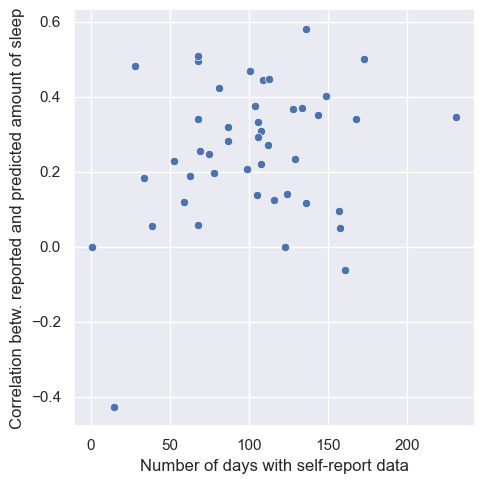

In [35]:
%matplotlib inline

sns.relplot(cor_reports, x='n', y='correlation') \
    .set(
        xlabel="Number of days with self-report data",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_self-report.png", dpi=300)

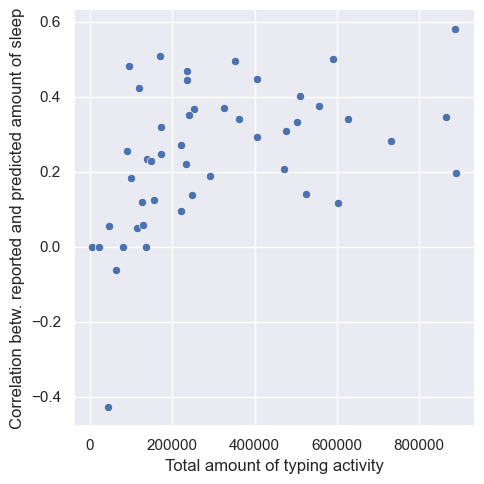

In [40]:
total_activities = [np.sum(np.array(res['Mactivity'])) for res in gsvd_results.values()]
cor_reports['activity'] = total_activities

sns.relplot(cor_reports, x='activity', y='correlation')\
    .set(
        xlabel="Total amount of typing activity",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity.png", dpi=300)

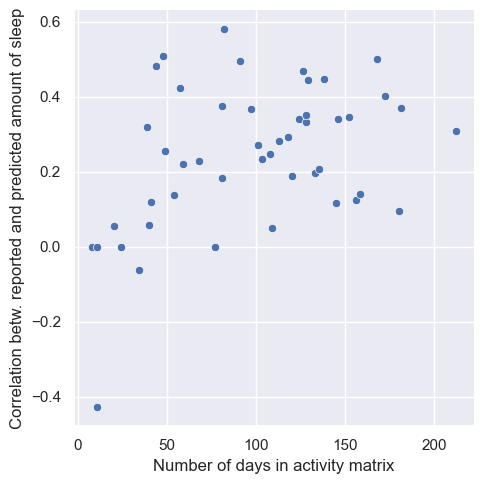

In [41]:
cor_reports['n_matrix'] = [len(res['Mactivity'].index) for res in gsvd_results.values()]

sns.relplot(cor_reports, x='n_matrix', y='correlation')\
    .set(
        xlabel="Number of days in activity matrix",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_days_mat.png", dpi=300)

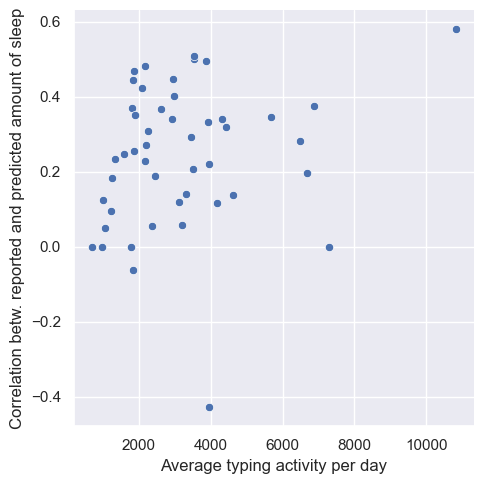

In [45]:
mats = [np.array(res['Mactivity']) for res in gsvd_results.values()]
cor_reports['activity_per_day'] = [np.sum(mat) / mat.shape[0] for mat in mats]

sns.relplot(cor_reports, x='activity_per_day', y='correlation')\
    .set(
        xlabel="Average typing activity per day",
        ylabel="Correlation betw. reported and predicted amount of sleep"
    )

plt.savefig("images/cor_activity_per_day.png", dpi=300)